In [116]:
import numpy as np

def get_band_data(loc, dates, b, mean=None, std=None):
    y = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy") for d in dates], axis=0)
    y = np.clip(y,0,30)
   
    x = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B{b}_{loc}_{d}.npy") for d in dates], axis=0)
    if mean is None:
        mean = x.mean()
        std = x.std()
    
    x = (x-mean)/std
    
    return x[:,:,:,None], y[:,:,:,None], mean, std

In [117]:
def get_band_data2(loc, dates, b, mean=None, std=None):
    y = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy") for d in dates], axis=0)
    y = np.clip(y,0,30)

    x11 = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B11_{loc}_{d}.npy") for d in dates], axis=0)
    xi = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B{b}_{loc}_{d}.npy") for d in dates], axis=0)

    if mean is None:
        mean = [x11.mean(),xi.mean()]
        std = [x11.std(),xi.std()]

    x11 = (x11-mean[0])/std[0]
    xi = (xi-mean[1])/std[1]

    x = np.stack((x11,xi), axis=3)
    x11 = None
    xi = None

    return x, y[:,:,:,None], mean, std

In [ ]:
dates = ["201811","201812","201901","201902"]
val = 0
b = 8
loc = "SYD"
_, _, mean, std = get_band_data(loc, [x for i, x in enumerate(dates) if i!=val], b)
x_test, y_test, _, _ = get_band_data(loc, [x for i, x in enumerate(dates) if i==val], b, mean, std)

In [ ]:
x_test.shape, x_test.min(), x_test.max(), x_test.mean(), x_test.std()

In [118]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras import backend as K

def get_unet():
    concat_axis = 3
    inputs = layers.Input(shape=(512, 512, 1))
    #ss = layers.Lambda(lambda x: x[:,:,:,1:], output_shape=(None,512,512,2))(inputs)

    feats = 8#16
    bn0 = BatchNormalization(axis=3)(inputs)
    
    conv1 = layers.Conv2D(feats, (3, 3), activation='relu', padding='same', name='conv1_1')(bn0)
    bn2 = BatchNormalization(axis=3)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn2) #256

    conv2 = layers.Conv2D(2*feats, (3, 3), activation='relu', padding='same')(pool1)
    bn4 = BatchNormalization(axis=3)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn4) #128

    conv3 = layers.Conv2D(4*feats, (3, 3), activation='relu', padding='same')(pool2)
    bn6 = BatchNormalization(axis=3)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn6) #64

    conv4 = layers.Conv2D(8*feats, (3, 3), activation='relu', padding='same')(pool3)
    bn8 = BatchNormalization(axis=3)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn8) #32

    conv5 = layers.Conv2D(16*feats, (3, 3), activation='relu', padding='same')(pool4)
    bn10 = BatchNormalization(axis=3)(conv5)
    pool5 = layers.MaxPooling2D(pool_size=(2, 2))(bn10) #16

    conv6 = layers.Conv2D(32*feats, (3, 3), activation='relu', padding='same')(pool5)
    bn11 = BatchNormalization(axis=3)(conv6)

    up_conv6 = layers.UpSampling2D(size=(2, 2))(bn11) #32
    up7 = layers.concatenate([up_conv6, conv5], axis=concat_axis)

    conv7 = layers.Conv2D(16*feats, (3, 3), activation='relu', padding='same')(up7)
    bn13 = BatchNormalization(axis=3)(conv7)
    
    up_conv5 = layers.UpSampling2D(size=(2, 2))(bn13) #64
    up6 = layers.concatenate([up_conv5, conv4], axis=concat_axis)

    conv6 = layers.Conv2D(8*feats, (3, 3), activation='relu', padding='same')(up6)
    bn15 = BatchNormalization(axis=3)(conv6)

    up_conv6 = layers.UpSampling2D(size=(2, 2))(bn15) #128
    up7 = layers.concatenate([up_conv6, conv3], axis=concat_axis)
    
    conv7 = layers.Conv2D(4*feats, (3, 3), activation='relu', padding='same')(up7)
    bn13 = BatchNormalization(axis=3)(conv7)

    # Rectify last convolution layer to constraint output to positive precipitation values.
    conv8 = layers.Conv2D(1, (1, 1), activation='relu')(bn13)

    model = models.Model(inputs=inputs, outputs=conv8)

    return model

In [119]:
def accuracy05(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>0.5,y_pred>0.5), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>0.5),tf.math.logical_not(y_pred>0.5)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision05(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>0.5,y_pred>0.5), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>0.5, tf.float32))
    
    return tp/(total_pred+K.epsilon())


def recall05(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>0.5,y_pred>0.5), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>0.5, tf.float32))
    
    return tp/(total_true+K.epsilon())


def accuracy1(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>1,y_pred>1), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>1),tf.math.logical_not(y_pred>1)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision1(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>1,y_pred>1), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>1, tf.float32))
    
    return tp/(total_pred+K.epsilon())


def recall1(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>1,y_pred>1), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>1, tf.float32))
    
    return tp/(total_true+K.epsilon())

def accuracy5(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>5,y_pred>5), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>5),tf.math.logical_not(y_pred>5)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision5(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>5,y_pred>5), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>5, tf.float32))
    
    return tp/(total_pred+K.epsilon())


def recall5(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>5,y_pred>5), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>5, tf.float32))
    
    return tp/(total_true+K.epsilon())


def accuracy10(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>10,y_pred>10), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>10),tf.math.logical_not(y_pred>10)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision10(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>10,y_pred>10), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>10, tf.float32))

    return tp/(total_pred+K.epsilon())


def recall10(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>10,y_pred>10), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>10, tf.float32))
    
    return tp/(total_true+K.epsilon())

In [ ]:
from numpy.random import seed
import pickle
import os

s = 1
seed(s)
tf.random.set_seed(s)

model = get_unet()
print(model.summary())
opt = Adagrad(lr=0.0001)
model.compile(loss='mse', metrics=[accuracy05,precision05,recall05,accuracy1,precision1,recall1,accuracy5,precision5,recall5,accuracy10,precision10,recall10], optimizer=opt)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), shuffle=True, epochs=200, verbose=1)

with open(f'history_3months_200epochs_8chann_v{val}_{loc}_s{s}_b{b}.pkl', 'wb') as f:
    pickle.dump(history.history, f)

model.save(f'model_3months_200epochs_8chann_v{val}_{loc}_s{s}_b{b}.h5')

In [ ]:
from tensorflow.keras.models import load_model

s = 1
mod = load_model(f'model_3months_200epochs_8chann_v{val}_{loc}_s{s}_b{b}.h5', 
                         custom_objects={'accuracy05':accuracy05, 'precision05':precision05, 'recall05':recall05,
                                         'accuracy1':accuracy1, 'precision1':precision1, 'recall1':recall1,
                                         'accuracy5':accuracy5, 'precision5':precision5, 'recall5':recall5,
                                         'accuracy10':accuracy10, 'precision10':precision10, 'recall10':recall10})

yhat = mod.predict(x_test)
yhat.shape

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

i = 600
plt.imshow(y_test[i,:,:,0])
y_test[i,:,:,0].max(), y_test[i,:,:,0].min()

In [ ]:
plt.imshow(yhat[i,:,:,0])
yhat[i,:,:,0].max(), yhat[i,:,:,0].min()

In [ ]:
mod2 = load_model(f'/data/GPM_HIM8/models/model_3months_200epochs_8chann_v{val}_{loc}_s1_b11.h5', 
                         custom_objects={'accuracy05':accuracy05, 'precision05':precision05, 'recall05':recall05,
                                         'accuracy1':accuracy1, 'precision1':precision1, 'recall1':recall1,
                                         'accuracy5':accuracy5, 'precision5':precision5, 'recall5':recall5,
                                         'accuracy10':accuracy10, 'precision10':precision10, 'recall10':recall10})

yhat2 = mod2.predict(x_test)
yhat2.shape

In [ ]:
plt.imshow(yhat2[i,:,:,0])
yhat2[i,:,:,0].max(), yhat2[i,:,:,0].min()

In [ ]:
from tensorflow.keras.models import load_model


dates = ["201811","201812","201901","201902"]

for loc in ["SYD", "NT", "WA"]:
    for val in range(4):
        for b in range(8,17):
            _, _, mean, std = get_band_data2(loc, [x for i, x in enumerate(dates) if i!=val], b)
            x_test, y_test, _, _ = get_band_data2(loc, [x for i, x in enumerate(dates) if i==val], b, mean, std)
            
            for i in range(5):
                print(loc, val, b, i)
                mod = load_model(f'/data/GPM_HIM8/models/model_3months_200epochs_8chann_v{val}_{loc}_s{i+1}_b11_{b}.h5', 
                                 custom_objects={'accuracy05':accuracy05, 'precision05':precision05, 'recall05':recall05,
                                                 'accuracy1':accuracy1, 'precision1':precision1, 'recall1':recall1,
                                                 'accuracy5':accuracy5, 'precision5':precision5, 'recall5':recall5,
                                                 'accuracy10':accuracy10, 'precision10':precision10, 'recall10':recall10})

                yhat = mod.predict(x_test)
                np.save(f'/data/GPM_HIM8/models/yhat_{loc}_v{val}_b11_{b}_s{i+1}', yhat)

SYD 0 8 0
SYD 0 8 1
SYD 0 8 2
SYD 0 8 3
SYD 0 8 4
SYD 0 9 0
SYD 0 9 1
SYD 0 9 2
SYD 0 9 3
SYD 0 9 4
SYD 0 10 0
SYD 0 10 1
SYD 0 10 2
SYD 0 10 3
SYD 0 10 4


## Interactive analysis of the results

In [1]:
import warnings
warnings.filterwarnings('ignore')

![alt text](regions_him.png	 "Logo Title Text 1")

### Load Data

In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

dates = ["201811","201812","201901","201902"]

yhats = []
y_test = None
location  = None
val_index = None

def f(loc, val):
    global location
    location = loc
    global y_test
    y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{val}.npy")
    y_test = np.clip(y_test,0,30)
    
    global yhats
    yhats = []
    val_i = dates.index(val)
    global val_index 
    val_index = val_i
    
    for b in range(8,17):
        for i in range(5):
            yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))
    
interactive(f, val=dates, loc=["SYD", "NT", "WA"], continuous_update=False)

interactive(children=(Dropdown(description='loc', options=('SYD', 'NT', 'WA'), value='SYD'), Dropdown(descript…

In [56]:
def f(n):
    plt.figure(figsize=(13,6))
    plt.plot(y_test.mean(axis=(1,2)))
    plt.axvline(x=n,linewidth=4, color='r')

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=729, description='n', max=1459), Output(layout=Layout(height='350px'))),…

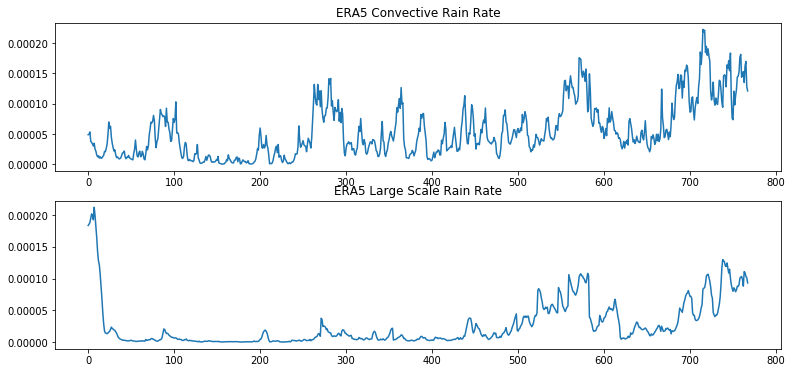

In [26]:
import xarray as xr

if val_index == 0:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018365.349083-15967-1-2d80aadb-da8a-4a1e-b8af-f3fd47e2be27.nc")
    t_range = slice("2018-11-01","2018-12-01")
if val_index == 1:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018365.349083-15967-1-2d80aadb-da8a-4a1e-b8af-f3fd47e2be27.nc")
    t_range = slice("2018-12-01","2019-01-01")
if val_index == 2:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018589.265387-5956-5-169d76fa-932a-461e-b362-551a527bfd39.nc")
    t_range = slice("2019-01-01","2019-02-01")
if val_index == 3:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018589.265387-5956-5-169d76fa-932a-461e-b362-551a527bfd39.nc")
    t_range = slice("2019-02-01","2019-03-01")

if location == "SYD":
    lons = slice(142,152)
    lats = slice(-31,-41)

if location == "NT":
    lons = slice(133,142)
    lats = slice(-11,-21)

if location == "WA":
    lons = slice(112,124)
    lats = slice(-24,-32)

#print(location, t_range, lats, lons)
f, axarr = plt.subplots(2,1, figsize=(13,6))
axarr[0].plot(ds.crr.sel(time=t_range,longitude=lons,latitude=lats).values.mean(axis=(1,2)))
axarr[0].set_title("ERA5 Convective Rain Rate")

axarr[1].plot(ds.lsrr.sel(time=t_range,longitude=lons,latitude=lats).values.mean(axis=(1,2)))
axarr[1].set_title("ERA5 Large Scale Rain Rate")

pass

In [27]:
def f(n):
    f, axarr = plt.subplots(5,10, figsize=(13,6))

    for b in range(9):
        for i in range(5):
            axarr[i,b].imshow(yhats[b*5+i][n,:,:,0], vmin=0, vmax=15)
            axarr[i,b].axis('off')
            
    for i in range(5):
        axarr[i,9].imshow(y_test[n,:,:], vmin=0, vmax=15)
        axarr[i,9].axis('off')

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=729, description='n', max=1459), Output(layout=Layout(height='350px'))),…

In [28]:
def f(n,t):
    f, axarr = plt.subplots(5,10, figsize=(13,6))

    for b in range(9):
        for i in range(5):
            axarr[i,b].imshow(yhats[b*5+i][n,:,:,0]>t)
            axarr[i,b].axis('off')
            
    for i in range(5):
        axarr[i,9].imshow(y_test[n,:,:]>t)
        axarr[i,9].axis('off')

    #plt.show()

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=729, description='n', max=1459), Dropdown(description='t', options=(0.5,…

In [7]:
def f(n,t):
    f, axarr = plt.subplots(1,2, figsize=(13,5))
    val_prec = []
    val_rec = []
    for b in range(9):
        precs = []
        recs = []
        for i in range(5):
            pred = yhats[b*5+i][n,:,:,0]>t
            obs = y_test[n,:,:]>t
            
            precs.append((obs*pred).sum()/pred.sum())
            recs.append((obs*pred).sum()/obs.sum())
        
        val_prec.append(precs)
        val_rec.append(recs)
        
    axarr[0].boxplot(np.array(val_prec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")
    
    axarr[1].boxplot(np.array(val_rec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Dropdown(description='t', options=(0.5,…

### Aggregations over 24 hours (48 time steps)

In [31]:
def f(n,t):
    f, axarr = plt.subplots(1,2, figsize=(13,5))
    val_prec = []
    val_rec = []
    for b in range(9):
        precs = []
        recs = []
        for i in range(5):
            pred = yhats[b*5+i][n-12:n+12,:,:,0]>t
            obs = y_test[n-12:n+12,:,:]>t
            
            precs.append((obs*pred).sum()/pred.sum())
            recs.append((obs*pred).sum()/obs.sum())
        
        val_prec.append(precs)
        val_rec.append(recs)
        
    axarr[0].boxplot(np.array(val_prec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")
    
    axarr[1].boxplot(np.array(val_rec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=729, description='n', max=1459), Dropdown(description='t', options=(0.5,…

### F1 scores over 24 hours
#### F1 = 2*(Recall * Precision) / (Recall + Precision)

In [30]:
def f(n,t):
    f, axarr = plt.subplots(1,1, figsize=(10,5))
    val_f1 = []
    for b in range(9):
        f1s = []
        for i in range(5):
            pred = yhats[b*5+i][n-12:n+12,:,:,0]>t
            obs = y_test[n-12:n+12,:,:]>t
            
            prec = (obs*pred).sum()/pred.sum()
            rec = (obs*pred).sum()/obs.sum()
                
            f1s.append((2*rec*prec)/(rec+prec))
        
        val_f1.append(f1s)
        
    axarr.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation F1 (at {t} mm/h)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=729, description='n', max=1459), Dropdown(description='t', options=(0.5,…

In [32]:
def f(n):
    f, axarr = plt.subplots(1,1, figsize=(7,4))
    val_mse = []
    for b in range(9):
        mses = []
        for i in range(5):
            pred = yhats[b*5+i][n,:,:,0]
            obs = y_test[n,:,:]
            
            mses.append(np.square(obs-pred).mean())
        
        val_mse.append(mses)
        
    axarr.boxplot(np.array(val_mse).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation Mean Square Error (MSE)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=729, description='n', max=1459), Output(layout=Layout(height='350px'))),…

<function find_peaks at 0x7f4c82b95ea0>


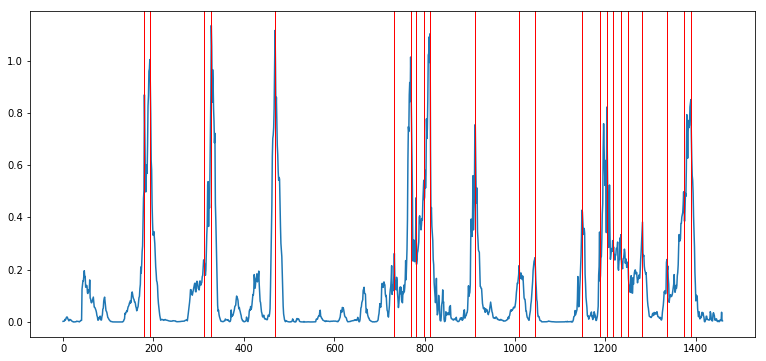

In [70]:
from scipy.signal import find_peaks

print(find_peaks)

prec_mean = y_test.mean(axis=(1,2))

plt.figure(figsize=(13,6))
plt.plot(prec_mean)
peaks, _ = find_peaks(prec_mean, height=.2,distance=12)
for p in peaks:
    plt.axvline(x=p,linewidth=1, color='r')

Text(0.5, 1.0, 'Validation F1 (at 0.5 mm/h)')

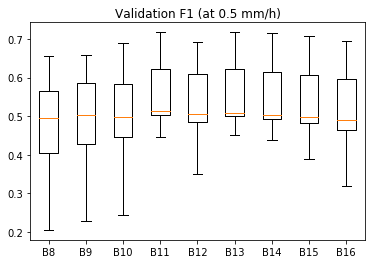

In [72]:
# Detect precipitation peaks

#thressholds
t_min = 0.5
t_max = 4

prec_mean = y_test.mean(axis=(1,2))
peaks1, _ = find_peaks(prec_mean, height=t_min,distance=12)
peaks2, _ = find_peaks(prec_mean, height=t_max,distance=12)
peaks = list(set(peaks1)-set(peaks2))
t = 0.5

val_f1 = []
for b in range(9):
    f1s = []
    for i in range(5):
        for p in peaks[1:-1]:
            pred = yhats[b*5+i][p-12:p+12,:,:,0]>t
            obs = y_test[p-12:p+12,:,:]>t

            prec = (obs*pred).sum()/pred.sum()
            rec = (obs*pred).sum()/obs.sum()

            f1s.append((2*rec*prec)/(rec+prec))

    val_f1.append(f1s)

plt.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
plt.title(f"Validation F1 (at {t} mm/h)")

==== 13
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1156 17207 25903
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 357 41552 39934
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 678 42982 32426
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1000 31903 45106
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 201 40287 44077
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 266 7095 6536
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 617 23230 17135
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1014 27877 42238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 343 54559 43322
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 568 27452 19917
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 665 37354 27613
(1459, 128, 

(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 678 26224 32426
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 1000 31037 45106
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 201 80590 44077
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 266 7430 6536
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 617 24053 17135
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 1014 28517 42238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 343 67614 43322
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 568 24387 19917
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 665 22942 27613
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 1156 29471 25903
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 357 40697 39934
(1459, 128, 128, 1) 

(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 343 82453 43322
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 568 23305 19917
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 665 26477 27613
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 1156 30543 25903
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 357 54741 39934
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 678 31493 32426
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 1000 39682 45106
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 201 84278 44077
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 266 11767 6536
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 617 24293 17135
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 1014 38615 42238
(1459, 128, 128, 1)

- 6 4 1000 37019 45106
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 201 92852 44077
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 266 9721 6536
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 617 26909 17135
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 1014 44257 42238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 343 77593 43322
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 568 22086 19917
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 665 25924 27613
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 1156 38242 25903
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 357 52560 39934
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 678 33952 32426
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 1000 36530 451

(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1156 6452 15764
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 357 21222 27992
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 678 25778 16571
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1000 14507 25632
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 201 11023 23902
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 266 2686 4556
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 617 10775 8788
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1014 9336 22548
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 343 25650 27205
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 568 14846 10469
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 665 22655 14875
(1459, 128, 128, 1) (14

(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 617 7633 8788
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 1014 6164 22548
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 343 33732 27205
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 568 9133 10469
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 665 9009 14875
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 1156 11343 15764
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 357 19391 27992
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 678 10637 16571
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 1000 6957 25632
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 201 25828 23902
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 2 266 2080 4556
(1459, 128, 128, 1) (1459,

- 4 3 357 31189 27992
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 678 13220 16571
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 1000 15136 25632
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 201 34852 23902
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 266 5370 4556
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 617 9393 8788
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 1014 11634 22548
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 343 42852 27205
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 568 8975 10469
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 3 665 11207 14875
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 4 1156 10099 15764
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 4 357 31556 27992
(

(24, 128, 128) (24, 128, 128)
- 6 4 343 40454 27205
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 568 7555 10469
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 4 665 8822 14875
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 1156 16529 15764
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 357 30916 27992
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 678 15692 16571
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 1000 13435 25632
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 201 43033 23902
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 266 4002 4556
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 617 7459 8788
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 7 0 1014 13943 22548
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128,

(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1156 2152 8530
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 357 8304 18299
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 678 12340 7754
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1000 5369 13880
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 201 1084 10581
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 266 682 3308
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 617 4108 4238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 1014 2259 10442
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 343 10714 15753
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 568 4947 4575
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 665 10807 7272
(1459, 128, 128, 1) (1459, 128, 1

(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 0 665 3425 7272
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 1156 3621 8530
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 357 6788 18299
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 678 3785 7754
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 1000 2115 13880
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 201 5519 10581
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 266 516 3308
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 617 2038 4238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 1014 1239 10442
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 343 11048 15753
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 2 1 568 2532 4575
(1459, 128, 128, 1) (1459, 128, 128

- 4 1 568 1927 4575
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 1 665 3409 7272
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 1156 2418 8530
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 357 8777 18299
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 678 3241 7754
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 1000 1888 13880
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 201 7005 10581
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 266 794 3308
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 617 2730 4238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 1014 766 10442
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 343 11797 15753
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 4 2 568 1626 4575
(1459, 128, 128,

(24, 128, 128) (24, 128, 128)
- 6 2 343 14321 15753
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 2 568 1416 4575
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 2 665 1879 7272
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 1156 4424 8530
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 357 11440 18299
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 678 4690 7754
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 1000 3245 13880
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 201 7574 10581
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 266 1383 3308
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 617 2599 4238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6 3 1014 2320 10442
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 6

- 8 3 1014 2550 10442
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 3 343 17202 15753
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 3 568 1388 4575
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 3 665 2691 7272
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 1156 4237 8530
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 357 14158 18299
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 678 4559 7754
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 1000 3160 13880
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 201 10732 10581
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 266 576 3308
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 617 2402 4238
(1459, 128, 128, 1) (1459, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 1014 1869 10442
(1459, 128,

(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 2 314 86781 63141
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 2 299 39578 47026
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 2 638 35663 27707
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 3 314 74254 63141
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 3 299 37184 47026
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 3 638 32273 27707
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 314 79941 63141
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 299 35992 47026
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 638 31467 27707
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 314 30585 42270
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 299 25430 32313
(1334, 128, 128, 1) (

- 8 4 299 13578 32313
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 638 12714 15887
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 314 14852 28302
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 299 13717 21652
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 0 638 2233 8331
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 1 314 14515 28302
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 1 299 14973 21652
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 1 638 2242 8331
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 2 314 12901 28302
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 2 299 12936 21652
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 2 638 2405 8331
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 0 3 314 12479 28302
(1334

(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 299 5045 21652
(1334, 128, 128, 1) (1334, 128, 128)
(24, 128, 128) (24, 128, 128)
- 8 4 638 3034 8331


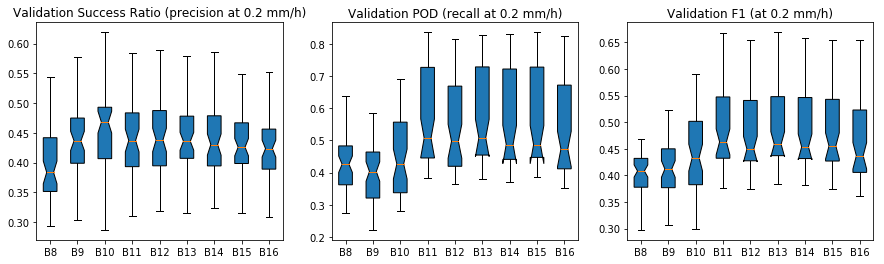

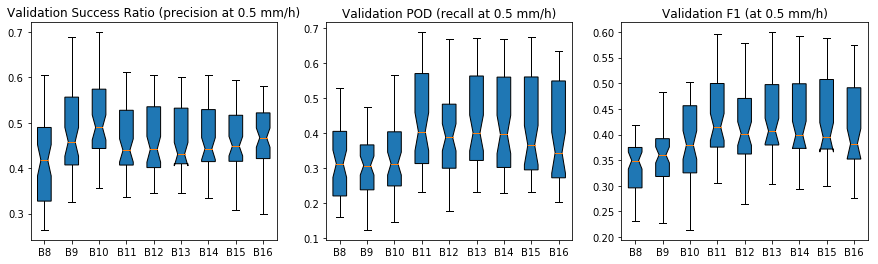

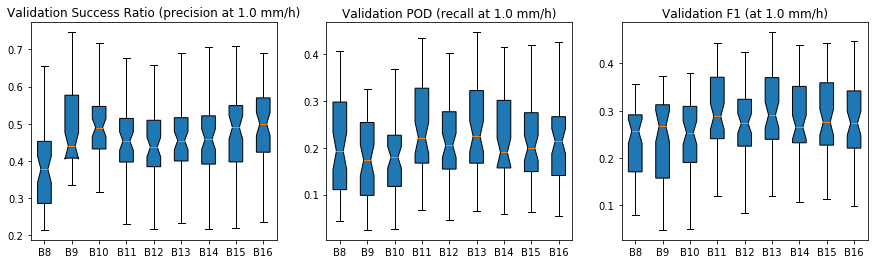

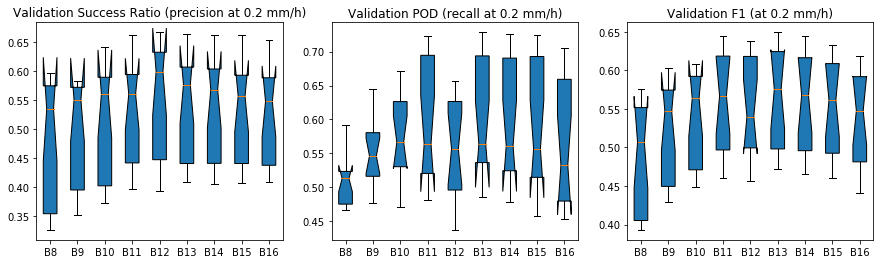

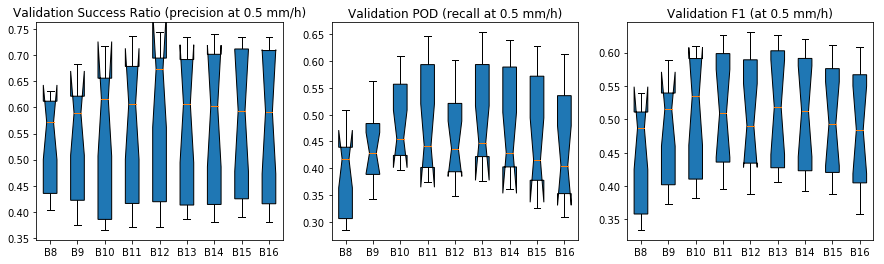

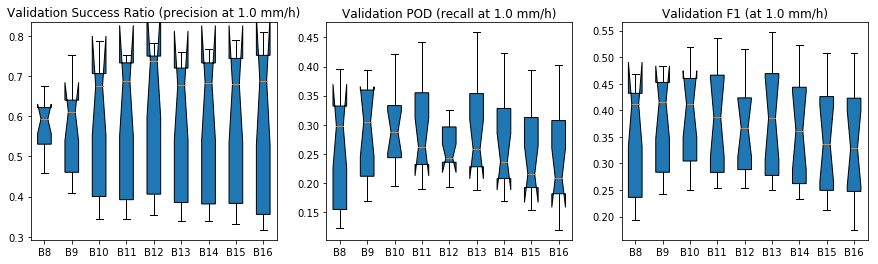

In [113]:
def plot_performance(yhats, y_test, t, peaks, fname):
    val_prec = []
    val_rec = []
    val_f1 = []
    for b in range(9):
        precs = []
        recs = []
        f1s = []
        for i in range(5):
            for p in peaks[1:-1]:
                
                print(yhats[0].shape, y_test.shape)
                pred = yhats[b*5+i][p-12:p+12,:,:,0]>t
                obs = y_test[p-12:p+12,:,:]>t
                
                print(pred.shape, obs.shape)
                
                if pred.sum()==0 or obs.sum()==0:
                    continue
                
                print("-",b,i,p,pred.sum(), obs.sum())

                prec = (obs*pred).sum()/pred.sum()
                rec = (obs*pred).sum()/obs.sum()

                precs.append(prec)
                recs.append(rec)
                f1s.append((2*rec*prec)/(rec+prec))

        val_prec.append(precs)
        val_rec.append(recs)
        val_f1.append(f1s)

    f, axarr = plt.subplots(1,3, figsize=(15,4))
    axarr[0].boxplot(np.array(val_prec).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")

    axarr[1].boxplot(np.array(val_rec).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")

    axarr[2].boxplot(np.array(val_f1).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[2].set_title(f"Validation F1 (at {t} mm/h)")
    
    f.savefig(fname)
    

dates = ["201811","201812","201901","201902"]
locations = ["SYD","NT","WA"]
locations = ["WA"]

for val_i in range(2,4):
    for loc in locations:
        y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{dates[val_i]}.npy")
        y_test = np.clip(y_test,0,30)
        yhats = []
        for b in range(8,17):
            for i in range(5):
                yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))
        
        t_min = 0.1
        t_max = 4

        prec_mean = y_test.mean(axis=(1,2))
        peaks1, _ = find_peaks(prec_mean, height=t_min,distance=12)
        peaks2, _ = find_peaks(prec_mean, height=t_max,distance=12)
        peaks = list(set(peaks1)-set(peaks2))
        print("====", len(peaks))
        
        for t in [0.2,0.5,1.0]:
            plot_performance(yhats, y_test, t, peaks, f'{loc}_{dates[val_i]}_t{t}.png')

In [114]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

dates = ["201811","201812","201901","201902"]

def f(loc, val):
    y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{val}.npy")
    y_test = np.clip(y_test,0,30)
    prec_mean = y_test.mean(axis=(1,2))
    
    plt.figure(figsize=(13,6))
    plt.plot(prec_mean)
    peaks, _ = find_peaks(prec_mean, height=.2,distance=12)
    for p in peaks:
        plt.axvline(x=p,linewidth=1, color='r')
    
interactive(f, val=dates, loc=["SYD", "NT", "WA"], continuous_update=False)

interactive(children=(Dropdown(description='loc', options=('SYD', 'NT', 'WA'), value='SYD'), Dropdown(descript…